In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import library
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [ ]:
# change directory
cd drive/MyDrive/time_series/

/content/drive/.shortcut-targets-by-id/153aUrsRMGEMxVeMr3_Rc-HCglOYysMia/time_series


In [ ]:
# load the data
State_time_series = pd.read_csv('/content/drive/My Drive/time_series/data/State_time_series.csv', parse_dates = True)
State_time_series.Date = pd.to_datetime(State_time_series.Date)
State_time_series['year'] = State_time_series.Date.dt.year

In [ ]:
# get costliest states
states = set(State_time_series[
    ~State_time_series['ZHVI_AllHomes'].isnull() &
    ~State_time_series['Sale_Prices'].isnull() & 
    ~State_time_series['ZHVIPerSqft_AllHomes'].isnull()
                      ]['RegionName'].values)

State_time_series_year = State_time_series[State_time_series['RegionName'].isin(states)].copy()
highest_cost_states = State_time_series_year[['RegionName', 'ZHVI_AllHomes']].groupby('RegionName').max().sort_values(by=['ZHVI_AllHomes'], ascending = False)[:5].index.values.tolist()
State_time_series_year = State_time_series_year[State_time_series_year.RegionName.isin(highest_cost_states)]
State_time_series_year.year = State_time_series_year.Date.dt.year

In [ ]:
# find the zhvi prices for top 5 states
states = ['DistrictofColumbia', 'California', 'Massachusetts', 'NewJersey', 'Washington']
zhvi_data = State_time_series_year[['Date','ZHVI_AllHomes','RegionName', 'ZHVIPerSqft_AllHomes']]

In [ ]:
# set lstm model directory
model_dir = './lstm_model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
# set test data size and window size
test_size = 24
window_size = 12

In [ ]:
# split train test data
def train_test_data(zhvi_data, state, test_size = test_size):
    state_zhvi_data = zhvi_data.loc[zhvi_data['RegionName'] == state]
    data = np.array(np.log(state_zhvi_data['ZHVIPerSqft_AllHomes']))
    date = np.array(state_zhvi_data['Date'])   
    
    train_data = data[:-test_size]
    test_data = data[-test_size:]

    return train_data, test_data, date    

In [ ]:
# scale training data
def train_data_scaler(train_data):
    scaler = MinMaxScaler(feature_range = (-1, 1))
    train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

    return train_data_normalized, scaler

In [ ]:
# split training data
def create_train_sequences(input_data, window_size = window_size):
    train_seqs = []
    l = len(input_data)
    for i in range(l - window_size):
        train_seq = input_data[i: i + window_size]
        train_label = input_data[i + window_size: i + window_size + 1]
        train_seqs.append((train_seq, train_label))
    return train_seqs

In [ ]:
# train lstm model
def train_model(model, state, train_seqs, test_inputs, epochs, model_dir = model_dir):

    train_loss_lst = []
    valid_loss_lst = []

    best_valid_loss = float('inf')
    for i in range(epochs):

        model.train()
        train_loss = 0

        for seq, labels in train_seqs:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            train_loss += loss
            loss.backward()
            optimizer.step()

        train_loss = train_loss / len(train_seqs)
        train_loss_lst.append(train_loss)

        model.eval()

        test_seq = test_inputs.copy()
        for j in range(test_size):
            seq = torch.FloatTensor(test_seq[-window_size:])
            test_seq.append(model(seq).item())

        predictions = test_seq[window_size:]
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(-1,)
        valid_loss = mean_squared_error(predictions, test_data)
        valid_loss_lst.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model, os.path.join(model_dir, 'lstm_' + state + '_persqrt.pt'))

        if (i + 1) % 25 == 0: 
            print('Epoch {} training loss: {:.5f}, validation loss {:.5f}.'.format(i + 1, train_loss, valid_loss))
            print('=' * 60)

    print('Training completed, best validation loss is {:.5f}'.format(best_valid_loss))

    return train_loss_lst, valid_loss_lst

In [ ]:
# evaluate model on test set
def model_score(model, test_inputs, scaler):
    model.eval()
    test_seq = test_inputs.copy()
    for i in range(test_size):
        seq = torch.FloatTensor(test_seq[-window_size:])
        test_seq.append(best_model(seq).item())
    actual_predictions = scaler.inverse_transform(np.array(test_seq[window_size:]).reshape(-1, 1)).reshape(-1, )
    mse = mean_squared_error(actual_predictions, test_data)

    return actual_predictions, mse

In [ ]:
# use the model to predict into the future
def model_predict(model, fut_pred, test_inputs, scaler):
    model.eval()
    test_seq = test_inputs.copy()
    for i in range(fut_pred):
        seq = torch.FloatTensor(test_seq[-window_size:])
        test_seq.append(best_model(seq).item())
    actual_predictions = scaler.inverse_transform(np.array(test_seq[window_size:]).reshape(-1, 1)).reshape(-1, )
    
    return actual_predictions    

In [ ]:
# produce timestamps in the future
def fut_timestamp(fut_pred, start):
    time_lst = []
    for yr in range(fut_pred // 12):
        time_lst += [str(start + yr) + '-' + str(n).zfill(2) for n in np.arange(1, 13)]
    time_lst += [str(start + yr + 1) + '-' + str(n).zfill(2) for n in np.arange(1, fut_pred % 12 + 1)]
    time_lst = np.array(pd.to_datetime(time_lst) + pd.offsets.MonthEnd())
    return time_lst

In [ ]:
# choose the state
state = 'Washington'

In [ ]:
# prepare training and test data
train_data, test_data, date = train_test_data(zhvi_data, state, test_size)
train_data_normalized, scaler = train_data_scaler(train_data)
train_seqs = create_train_sequences(train_data_normalized, window_size)
test_inputs = train_data_normalized[-window_size:].tolist()

In [ ]:
# define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_layer_size = 32, output_size = 1):
       
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))

        return predictions[-1]

In [ ]:
# initialize model
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)
epochs = 150

In [ ]:
# train and save model
train_loss_lst, valid_loss_lst = train_model(model, state, train_seqs, test_inputs, epochs)

Epoch 25 training loss: 0.00831, validation loss 0.02252.
Epoch 50 training loss: 0.00474, validation loss 0.05060.
Epoch 75 training loss: 0.00117, validation loss 0.08346.
Epoch 100 training loss: 0.00029, validation loss 0.00947.
Epoch 125 training loss: 0.00027, validation loss 0.01563.
Epoch 150 training loss: 0.00025, validation loss 0.00407.
Training completed, best validation loss is 0.00229


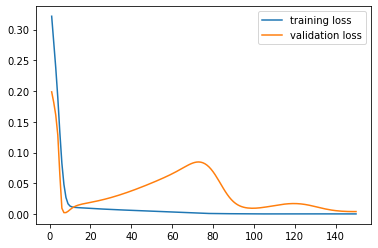

In [ ]:
# plot losses
plt.plot(np.arange(1, epochs + 1), train_loss_lst, label = 'training loss')
plt.plot(np.arange(1, epochs + 1), valid_loss_lst, label = 'validation loss')
plt.legend()
plt.show()

In [ ]:
# load model
best_model = torch.load(os.path.join(model_dir, 'lstm_' + state + '_persqrt.pt'))

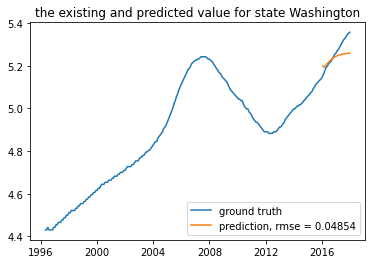

In [ ]:
# evaluate model on test data
prediction, mse = model_score(best_model, test_inputs, scaler)
plt.plot(date, np.concatenate([train_data, test_data]), label = 'ground truth')
plt.plot(date[-test_size:], prediction, label = 'prediction, rmse = {:.5f}'.format(np.sqrt(mse)))
plt.title('the existing and predicted value for state Washington')
plt.legend()
plt.show()

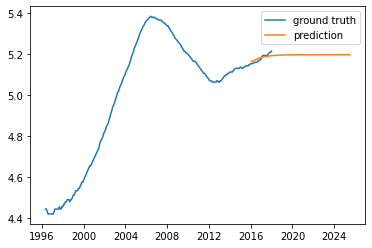

In [ ]:
# predict into the future
fut_pred = 114
longer_prediction = model_predict(best_model, fut_pred, test_inputs, scaler)
plt.plot(date, np.concatenate([train_data, test_data]), label = 'ground truth')
plt.plot(np.concatenate([date[-test_size:], fut_timestamp(fut_pred - test_size, 2018)]), longer_prediction, label = 'prediction')
plt.legend()
plt.show()